<a href="https://colab.research.google.com/github/SamuelBM21/IC/blob/main/HorsesOrHumans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch                        #PyTorch
import torch.nn as nn               #Camadas da Rede neural
import torch.optim as optim         #Otimizadores
import torchvision                  #Datasets
import numpy as np
import random
from torchvision import transforms,datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt     #Visualização

In [ ]:
batch_size = 64
learning_rate = 0.001
epochs = 25

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((160, 160)),          # Redimensiona para um tamanho ligeiramente maior
    transforms.RandomCrop((150, 150)),      # Recorte aleatório para o tamanho desejado
    transforms.RandomHorizontalFlip(p=0.5), # Inversão horizontal com 50% de chance
    transforms.RandomRotation(15),          # Rotação de até ±15 graus
    transforms.ColorJitter(
        brightness=0.2,                     # Variação de brilho (±20%)
        contrast=0.2,                       # Variação de contraste (±20%)
        saturation=0.2,                     # Variação de saturação (±20%)
        hue=0.1                             # Variação de matiz (±10%)
    ),
    transforms.RandomAffine(
        degrees=0,                      # Sem rotação adicional
        translate=(0.1, 0.1),           # Translação horizontal/vertical de até 10%
        scale=(0.9, 1.1)                # Zoom aleatório entre 90% e 110%
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Valores do ImageNet
])

test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Mesma normalização
])

train_data = datasets.ImageFolder('/content/drive/MyDrive/DataSets/horsehuman_train', transform=train_transforms)
test_data = datasets.ImageFolder('/content/drive/MyDrive/DataSets/horsehuman_test', transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # saída: 32 x 150 x 150
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # saída: 32 x 75 x 75

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # saída: 64 x 75 x 75
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # saída: 64 x 37 x 37

            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # saída 128 x 37 x 37
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 128 x 18 x 18

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256 x 18 x 18
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)                                 # 256 x 9 x 9
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 9 * 9, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
for epoch in range(epochs):
    model.train()                               #Modo treino
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)                 #Passa imagens pela rede
        loss = criterion(outputs, labels)       #Calcula perda

        optimizer.zero_grad()                   #Zera gradientes antigos
        loss.backward()                         #Back propagation
        optimizer.step()                        #Atualiza os pesos

    print(f"Época {epoch+1}/{epochs} - Loss: {loss.item():.4f}")


Época 1/25 - Loss: 0.5974
Época 2/25 - Loss: 0.6831
Época 3/25 - Loss: 0.1694
Época 4/25 - Loss: 0.2683
Época 5/25 - Loss: 0.2470
Época 6/25 - Loss: 0.1409
Época 7/25 - Loss: 0.1380
Época 8/25 - Loss: 0.1377
Época 9/25 - Loss: 0.1611
Época 10/25 - Loss: 0.0555
Época 11/25 - Loss: 0.2082
Época 12/25 - Loss: 0.0333
Época 13/25 - Loss: 0.0301
Época 14/25 - Loss: 0.0371
Época 15/25 - Loss: 0.0323
Época 16/25 - Loss: 0.1731
Época 17/25 - Loss: 0.0149
Época 18/25 - Loss: 0.0071
Época 19/25 - Loss: 0.1839
Época 20/25 - Loss: 0.0427
Época 21/25 - Loss: 0.0146
Época 22/25 - Loss: 0.0034
Época 23/25 - Loss: 0.0413
Época 24/25 - Loss: 0.0535
Época 25/25 - Loss: 0.0853


In [ ]:
#IMAGENS DE TESTE

model.eval()    #Modo avaliação
correct = 0
total = 0
with torch.no_grad():                               #Não computa gradientes
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)                     # Faz predição
        predicted = (torch.sigmoid(outputs) >= 0.5).float().squeeze()  # Escolhe classe com maior probabilidade
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Acurácia no teste: {100 * correct / total:.2f}%")

Acurácia no teste: 76.95%


In [ ]:
#IMAGENS DE TREINO


model.eval()    #Modo avaliação
correct = 0
total = 0
with torch.no_grad():                               #Não computa gradientes
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)                     # Faz predição
        predicted = (torch.sigmoid(outputs) >= 0.5).float().squeeze()  # Escolhe classe com maior probabilidade
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Acurácia no teste: {100 * correct / total:.2f}%")

Acurácia no teste: 94.47%


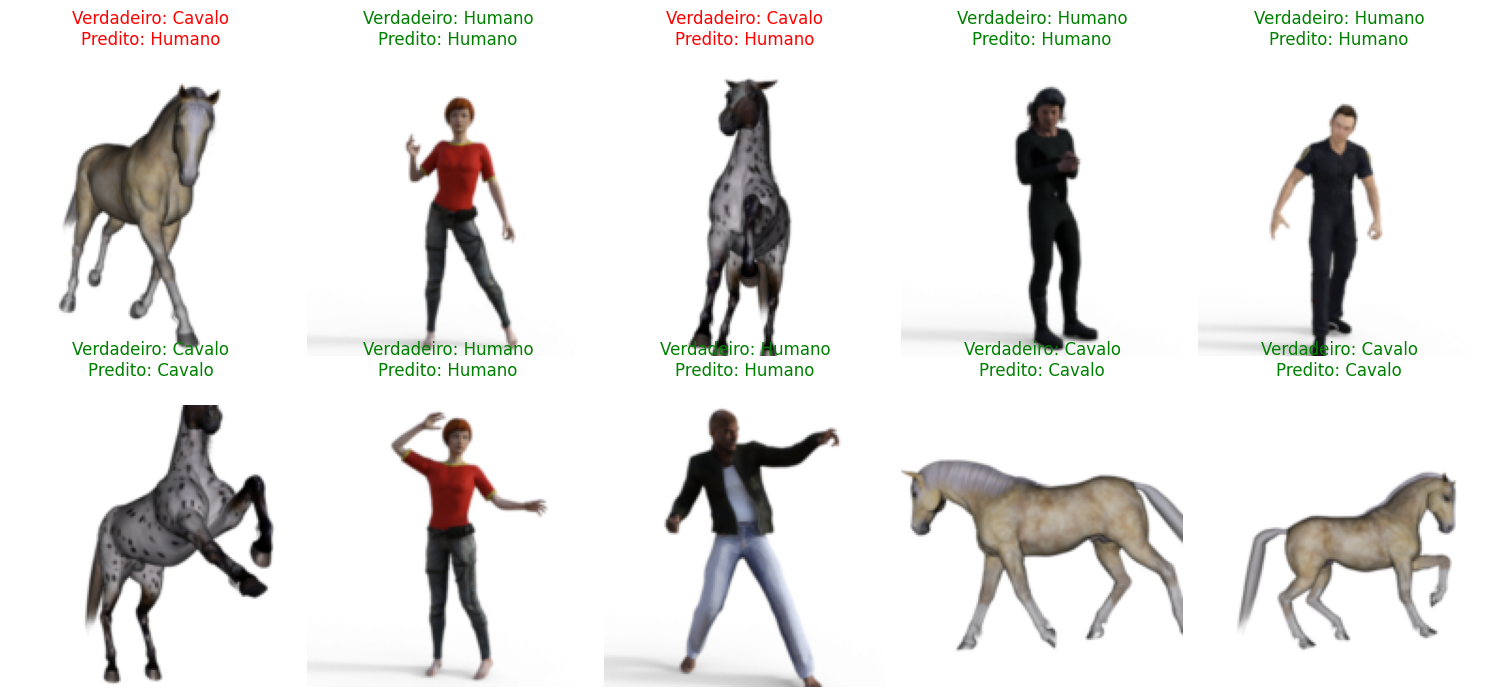

In [ ]:

def visualize_predictions(model, test_loader, device, num_images=10):
    model.eval()
    classes = ['Cavalo', 'Humano']
    dataset = test_loader.dataset  # Acessa o dataset original

    # Seleciona índices aleatórios
    random_indices = random.sample(range(len(dataset)), num_images)

    # Cria um batch personalizado com as imagens escolhidas
    images = []
    labels = []
    for idx in random_indices:
        img, lbl = dataset[idx]  # Pega imagem e label do dataset
        images.append(img.unsqueeze(0))  # Adiciona dimensão do batch
        labels.append(lbl)

    # Converte para tensor e envia para o dispositivo
    images = torch.cat(images, dim=0).to(device)
    labels = torch.tensor(labels).to(device)

    # Faz as predições
    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).float().squeeze()

    # Desnormaliza as imagens CORRETAMENTE
    images = images.cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images = images * std + mean
    images = images.permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

    # Prepara os dados para plotagem
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plota as imagens
    plt.figure(figsize=(15, 7))
    for idx in range(num_images):
        ax = plt.subplot(2, 5, idx+1)
        plt.imshow(images[idx])

        true_label = classes[labels[idx]]
        pred_label = classes[int(preds[idx])]

        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"Verdadeiro: {true_label}\nPredito: {pred_label}\n", color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, device, num_images=10)